### How to run Metrcs on WFD area only using Feasture-based OpSims
Since featured-based OpSim scheduler no longer uses fixed tiles in the sky to plan observations, the WFD footprint can't be easily defined. With the feature-based opsim, there are two ways to run metrics on 'WFD' observations, the first one is introduced in this notebook and another is mentioned in [DDF_Other_FootPrint.ipynb](./03_DDF_Other_FootPrint.ipynb). More in-depth discussion on this topic can be found in this [thread](https://community.lsst.org/t/wfd-metrics-with-the-fbs-output/3970).

The trick introduced here is to define a `HealpixSubsetSlicer` which uses a customized mask to run metric on the WFD region only. This notebook is merely a replicate of the notebook [here](https://github.com/LSST-nonproject/sims_maf_contrib/blob/master/tutorials/WFD%20footprint%20demo.ipynb) 

In [1]:
import os
import numpy as np
import pandas as pd
import healpy as hp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For the WFD footprint definitions
from lsst.sims.featureScheduler import utils as schedUtils

In [3]:
# To calculate metrics with MAF
import lsst.sims.maf.db as db
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as mb
import lsst.sims.maf.plots as plots
import lsst.sims.maf.batches as batches

In [5]:
# specify path to the opsim database and create database object
dbfile = '/home/idies/workspace/lsst_cadence/FBS_1.5/baseline_v1.5_10yrs.db'
outDir = '../tmp/'
opsdb = db.OpsimDatabase(dbfile)

In [6]:
# Let's count the visits .. 
metric = metrics.CountMetric('observationStartMJD', metricName='nvisits')

In [7]:
# .. over the WFD region - so define the WFD footprint first.
nside = 64
wfd_standard = schedUtils.WFD_no_gp_healpixels(nside, dec_max=2.5, dec_min=-62.5)
wfd_bigdust = schedUtils.WFD_no_dust_healpixels(nside, dec_max=12.25, dec_min=-72.5, dust_limit=0.19)

#### 1. Visualize two WFD footprints

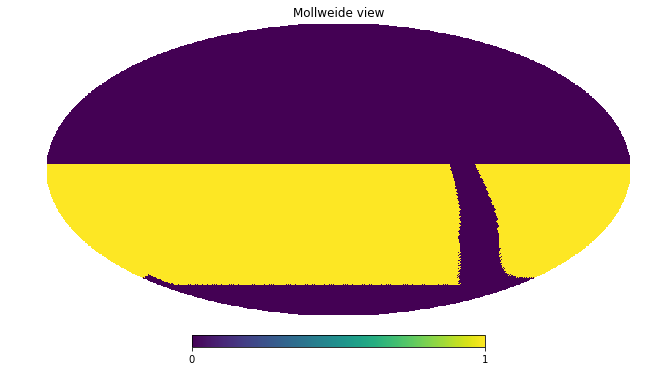

In [8]:
hp.mollview(wfd_standard)

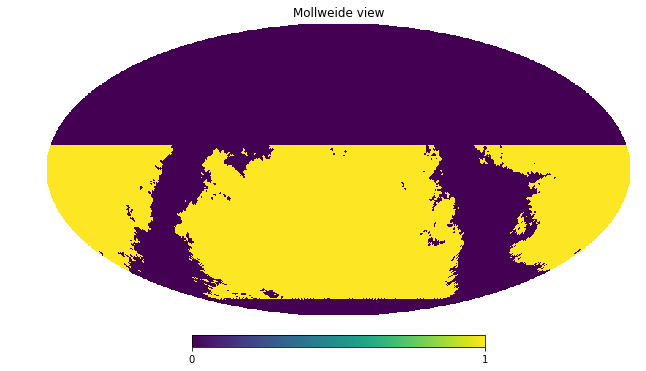

In [9]:
hp.mollview(wfd_bigdust)

#### 2. Use a custom WFD slicer defined using `HealpixSubsectSlicer` to run metric

In [10]:
# we'll use the standard WFD here, as that is what was used with the baseline.
slicer = slicers.HealpixSubsetSlicer(nside, np.where(wfd_standard==1)[0])

HealpixSubsetSlicer using NSIDE=64, approximate resolution 54.967783 arcminutes


In [11]:
# And we will skip DD visits, so add a constraint to avoid them.
constraint = 'note not like "DD%"'

In [12]:
bundle = mb.MetricBundle(metric, slicer, constraint, metadata='WFD only')

In [13]:
g = mb.MetricBundleGroup({'0': bundle}, opsdb, outDir=outDir)
g.runAll()

Querying database SummaryAllProps with constraint note not like "DD%" for columns ['observationStartMJD', 'fieldDec', 'fieldRA']
Found 2122606 visits
Running:  ['0']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


/home/idies/lsst/stack/miniconda3-4.7.10-4d7b902/Linux64/sims_maf/2.13.0.sims-24-gbe21ed04+1/python/lsst/sims/maf/utils/mafUtils.py:58: UserWarning: Optimal bin calculation tried to make 226 bins, returning 200
  warnings.warn('Optimal bin calculation tried to make %.0f bins, returning %i'%(nbins, nbinMax))


monopole: 960.84  dipole: lon: -101.043, lat: -35.0843, amp: 26.9143


{'SkyMap': 1, 'Histogram': 2, 'PowerSpectrum': 3}

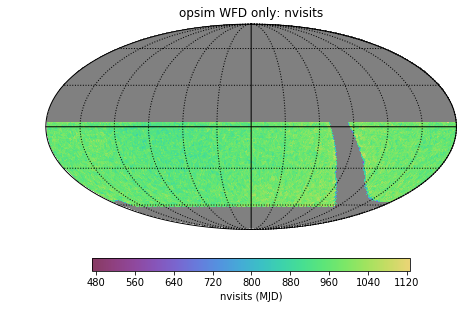

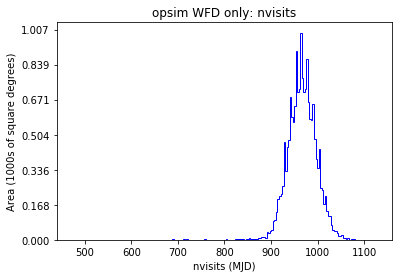

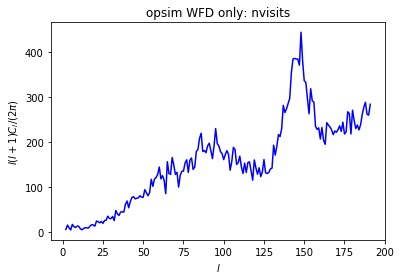

In [14]:
# Let's look at the plots - you get the standard healpix SkyMap, Area Histogram, and powerspectrum. 
bundle.plot()

##### Show summary statistics

In [15]:
# We can also add some summary statistics, which will only be calculated over the WFD footprint (obviously).
bundle.setSummaryMetrics(batches.extendedSummary())
bundle.computeSummaryStats()

In [16]:
# Look at the summary values calculated - pandas DataFrame makes a nice view
pd.DataFrame(bundle.summaryValues, index=['Baseline WFD'])

,Mean,Rms,Median,Count,Max,Min,N(+3Sigma),N(-3Sigma),25th%ile,75th%ile
Baseline WFD,965.891275,31.234818,966.0,21191,1126.0,473.0,37,88,946.0,986.0
